# Fall Detection using CNN-BiLSTM and WedaFall Dataset

## 1. Libraries and variables

In [1]:
from pytorch_lightning.demos import SimpleLSTM

from dataset.FallAllDDataset import FallAllDDataset
from models.HybridCNNBiLSTMModel import HybridCNNBiLSTMModel
from utils.utils import plot_sensor_data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, Subset
from collections import Counter
from models.CBAM_IAM_CNN_BiLSTM import CBAM_IAM_CNN_BiLSTM
from pytorch_lightning import Trainer
import wandb
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime
import pandas as pd

dataset_path = "B:\\Dataset\\FallAllD\\"
learning_rate = 0.001
batch_size = 64
dropout = 0.3

## 2. Dataset

### 2.1 Dataset initialization

In [2]:
dataset = FallAllDDataset(dataset_path, accellerometer=True, gyroscope=True)

Processing files: 100%|██████████| 26420/26420 [01:03<00:00, 418.64it/s] 


### 2.2 Dataset exploration

In [3]:
print(f"Dataset length: {len(dataset)}")
classes = dataset.classes()
print(f"\tActivities: {classes[0]}")
print(f"\tFalls: {classes[1]}")

Dataset length: 1798
	Activities: 1332
	Falls: 466


#### 2.2.1 Sample data

Subject: 07, Activity: 109, Trial: 01, Label: 1
397 records in vertical accelerometer data
397 records in vertical accelerometer data


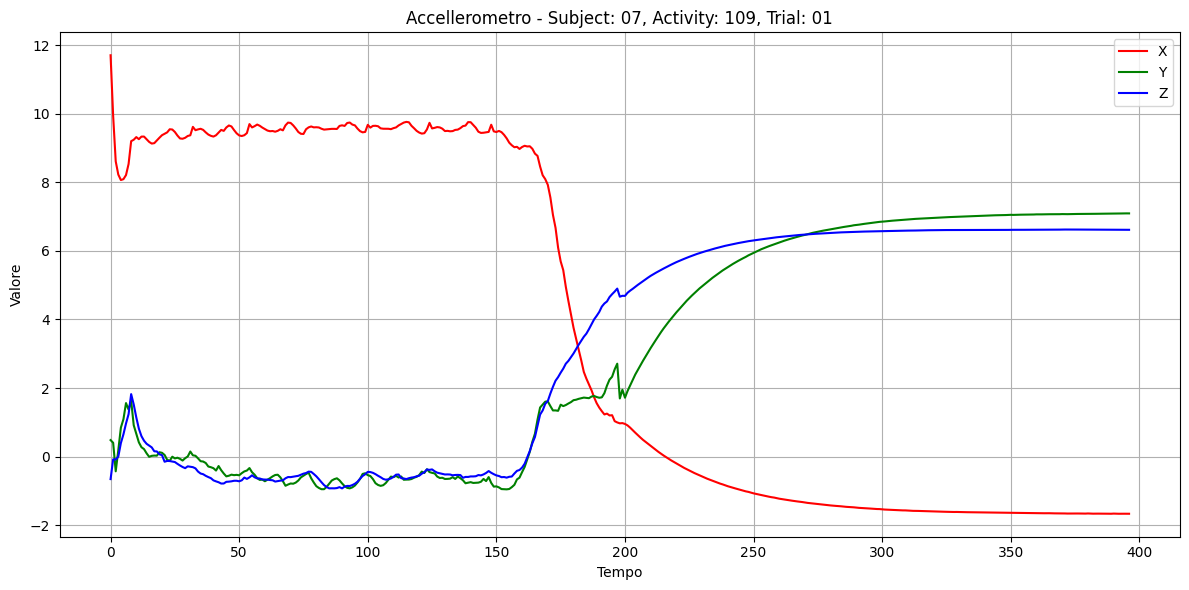

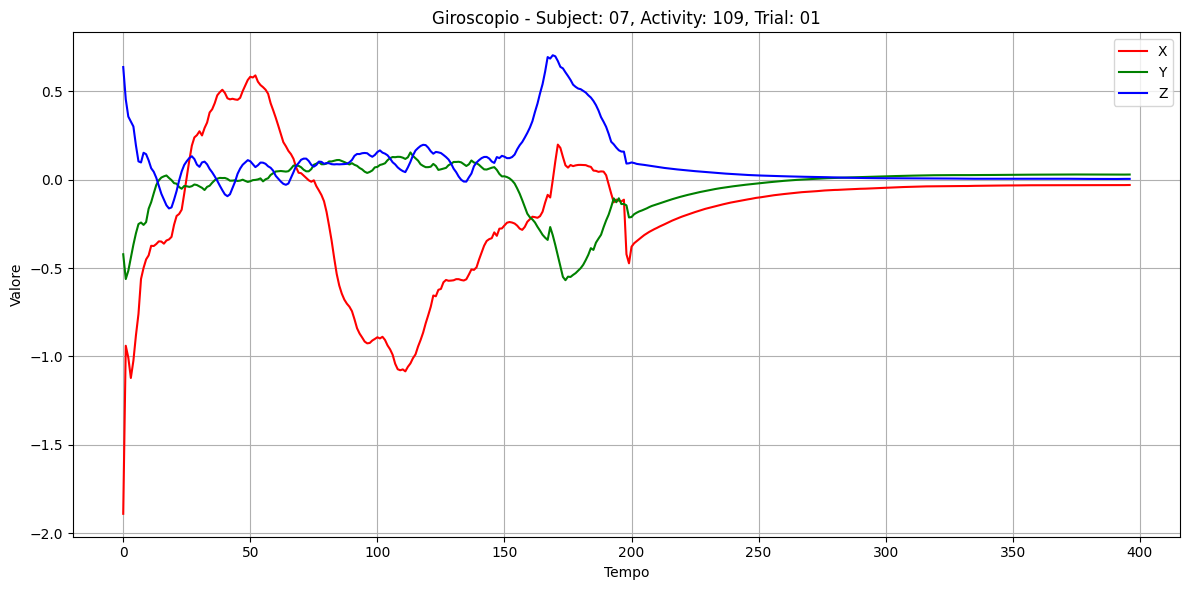

In [4]:
sample = dataset[811]
print(f"Subject: {sample['subject']}, Activity: {sample['activity']}, Trial: {sample['trial']}, Label: {sample['label']}")
print(f"{len(sample['A'])} records in vertical accelerometer data")
print(f"{len(sample['G'])} records in vertical accelerometer data")

plot_sensor_data(pd.DataFrame(sample['A'], columns=['x', 'y', 'z']), sensor_type='A', labels=f"Accellerometro - Subject: {sample['subject']}, Activity: {sample['activity']}, Trial: {sample['trial']}")
plot_sensor_data(pd.DataFrame(sample['G'], columns=['x', 'y', 'z']), sensor_type='G', labels=f"Giroscopio - Subject: {sample['subject']}, Activity: {sample['activity']}, Trial: {sample['trial']}")

### 2.3 Dataset statistics after preprocessing with windowing

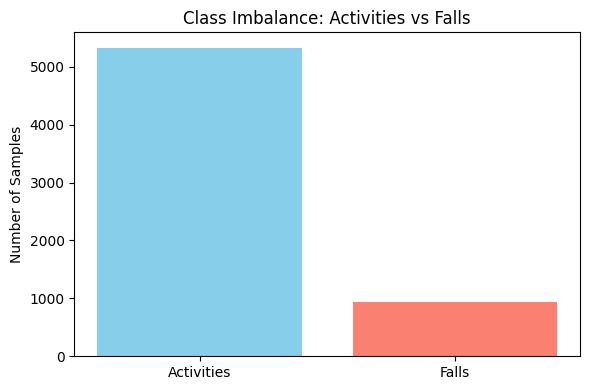

Dataset length: 6260
	Activities: 5328
	Falls: 932


In [5]:
dataset.setVisualization(False)

labels = ['Activities', 'Falls']
classes = dataset.classes()

plt.figure(figsize=(6, 4))
plt.bar(labels, [classes[0], classes[1]], color=['skyblue', 'salmon'])

plt.title('Class Imbalance: Activities vs Falls')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

print(f"Dataset length: {len(dataset)}")
print(f"\tActivities: {classes[0]}")
print(f"\tFalls: {classes[1]}")

#### 2.3.1 Item example

In [6]:
features, label = dataset[4]
print(f"Label: {label}")
print(f"Features shape: {features.shape}")
print(features)

Label: 0
Features shape: (6, 140)
[[ 8.9450331e+00  9.0066509e+00  9.0295954e+00  9.0293341e+00
   9.0220146e+00  9.0147276e+00  9.0082502e+00  9.0032654e+00
   9.0055981e+00  9.0017128e+00  9.0044966e+00  9.0056562e+00
   8.9997749e+00  8.9980621e+00  8.9982147e+00  9.0032806e+00
   8.9988832e+00  8.9969721e+00  8.9980373e+00  8.9949465e+00
   8.9975128e+00  8.9977798e+00  8.9986477e+00  8.9996853e+00
   8.9997044e+00  8.9973354e+00  8.9970198e+00  8.9974823e+00
   8.9979134e+00  8.9987297e+00  8.9980793e+00  8.9998503e+00
   9.0008354e+00  9.0028200e+00  9.0036564e+00  9.0041695e+00
   9.0041046e+00  9.0053120e+00  9.0069075e+00  9.0082483e+00
   9.0082130e+00  9.0099134e+00  9.0111074e+00  9.0132704e+00
   9.0149174e+00  9.0147333e+00  9.0161381e+00  9.0162449e+00
   9.0166769e+00  9.0178251e+00  9.0179539e+00  9.0190477e+00
   9.0200186e+00  9.0209522e+00  9.0220098e+00  9.0212831e+00
   9.0212946e+00  9.0209913e+00  9.0213261e+00  9.0199280e+00
   9.0210752e+00  9.0217152e+00  9.0

In [7]:
random_state = 42
validation_and_test = 0.3
test_size = 0.6


labels = np.array([dataset[i][1] for i in range(len(dataset))])
indices = np.arange(len(labels))


train_idx, temp_idx, y_train, y_temp = train_test_split(indices, labels, test_size=validation_and_test, stratify=labels, random_state=random_state)
val_idx, test_idx, _, _ = train_test_split(temp_idx, y_temp, test_size=test_size, stratify=y_temp, random_state=random_state)


train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

#### 2.4.1 Class distribution

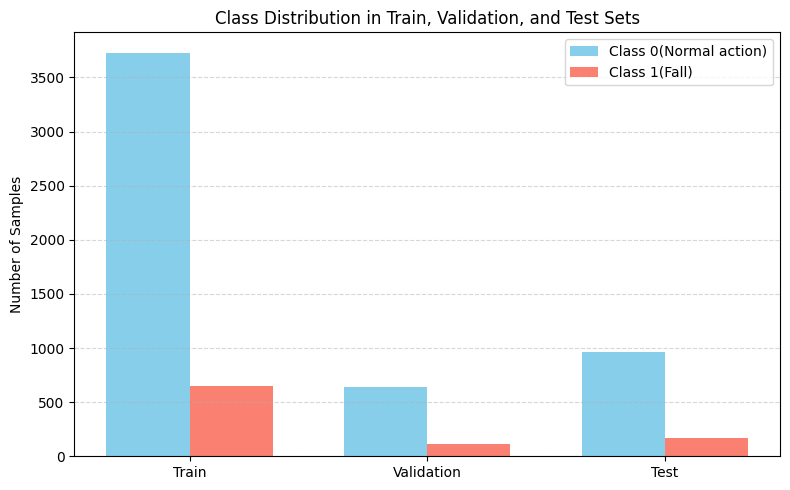

Train dataset length: 4382
Validation dataset length: 751
Test dataset length: 1127


In [8]:
def count_labels(dataloader):
    label_counter = Counter()
    for _, labels in dataloader:
        label_counter.update(labels.numpy().tolist())
    return label_counter

train_counts = count_labels(train_loader)
val_counts = count_labels(val_loader)
test_counts = count_labels(test_loader)


splits = ['Train', 'Validation', 'Test']
class_0 = [train_counts[0], val_counts[0], test_counts[0]]
class_1 = [train_counts[1], val_counts[1], test_counts[1]]

x = range(len(splits))
width = 0.35


plt.figure(figsize=(8, 5))
plt.bar(x, class_0, width=width, label='Class 0(Normal action)', color='skyblue')
plt.bar([p + width for p in x], class_1, width=width, label='Class 1(Fall)', color='salmon')

plt.xticks([p + width/2 for p in x], splits)
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Train, Validation, and Test Sets")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

## 3. Model

In [9]:
from models.LSTM import SimpleLSTMModel

model = SimpleLSTMModel(input_len=140, dropout=dropout, weights=[train_counts[0], train_counts[1]])

#### 3.1 WandB integration

In [10]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

wandb_logger = WandbLogger(
    project="fall-detection",
    name=f"lstm-{timestamp}",
)

config = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "dropout": dropout,
    "model": "lstm",
}
wandb_logger.experiment.config.update(config)

wandb: Currently logged in as: zznnp (zznnp-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


#### 3.2 Lightning module

In [11]:
trainer = Trainer(
    max_epochs=30,
    accelerator='gpu',
    devices=1,
    num_sanity_val_steps=0,
    check_val_every_n_epoch=1,
    enable_progress_bar=False,
    logger=wandb_logger
    #callbacks=[checkpoint_cb, earlystop_cb]
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | lstm      | LSTM             | 534 K  | train
1 | dropout   | Dropout          | 0      | train
2 | fc1       | Linear           | 4.6 M  | train
3 | fc2       | Linear           | 258    | train
4 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.490    Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


In [12]:
res = trainer.test(model, dataloaders=test_loader)
print(f"Test results: {res}")

wandb.finish(0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9778172373771667
         test_f1            0.9782998561859131
        test_loss           0.07194315642118454
     test_precision         0.9797468185424805
       test_recall          0.9778172373771667
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test results: [{'test_loss': 0.07194315642118454, 'test_accuracy': 0.9778172373771667, 'test_precision': 0.9797468185424805, 'test_recall': 0.9778172373771667, 'test_f1': 0.9782998561859131}]


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
test_accuracy,▁▁
test_f1,▁▁
test_loss,▁
test_precision,▁▁
test_recall,▁▁
train_acc_epoch,▁▃▆▆▆▁█▃█▆▆███▆▆▆▃█▆▆██▆█████▆
train_acc_step,▁▄▅██▆▇▆▄▄▄█▇▆▃▃▅█▆▇▇▄▅▃▆▆▅▄▇▆▅▆▅█▅▅▇█▆▆
train_loss_epoch,▇▅▂▄▂█▂▃▃▃▂▁▁▁▄▂▂▃▁▂▄▁▁▅▁▁▁▁▁▂
train_loss_step,▄▂▃▃▃▁▄▂▇▂▁█▂▂▁▂▁▁▁▁▄▃▂▁▁▁▄▁▂▇▁▁▁▃▆▁▁▁▁▂
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▆▂▂▂▂▂▂▇▂▂▂▂█▂█
